# SNN-ANN Model

In [1]:
! pip install snntorch

  Obtaining dependency information for snntorch from https://files.pythonhosted.org/packages/4b/55/95ee9e0e26cf74a464603ef7ab84be186133bfb95ac0c5ae9d1eb408b69b/snntorch-0.7.0-py2.py3-none-any.whl.metadata
  Obtaining dependency information for nir from https://files.pythonhosted.org/packages/a8/e1/60b9014266c26d170b2f1bc7fe1b7b6ad823ad8cb302104ca306685311ac/nir-1.0.1-py3-none-any.whl.metadata
  Obtaining dependency information for nirtorch from https://files.pythonhosted.org/packages/cd/74/92cc684fd83636b072318693676877af0d80c4e136067237f147f9a18d6f/nirtorch-1.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 1.4 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.2/76.2 kB 5.9 MB/s eta 0:00:00


In [2]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision import utils as utls

import snntorch as snn
from snntorch import utils
from snntorch import surrogate

import numpy as np
import torch.optim as optim

In [7]:
class HybridSNNANN(nn.Module):
    def __init__(self, beta, thresh, latent_dim, num_steps):
        super(HybridSNNANN, self).__init__()
        self.num_steps = num_steps

        # SNN Encoder
        self.snn_encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1, stride=2),
            nn.BatchNorm2d(32),
            snn.Leaky(beta=beta, threshold=thresh, init_hidden=True),
            nn.Conv2d(32, 64, 3, padding=1, stride=2),
            nn.BatchNorm2d(64),
            snn.Leaky(beta=beta, threshold=thresh, init_hidden=True),
            nn.Conv2d(64, 128, 3, padding=1, stride=2),
            nn.BatchNorm2d(128),
            snn.Leaky(beta=beta, threshold=thresh, init_hidden=True),
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, latent_dim),
            snn.Leaky(beta=beta, threshold=thresh, init_hidden=True, output=True)
        )

        # ANN Decoder
        self.ann_decoder = nn.Sequential(
            nn.Linear(latent_dim, 128 * 4 * 4),
            nn.ReLU(),
            nn.Unflatten(1, (128, 4, 4)),
            nn.ConvTranspose2d(128, 64, 3, padding=1, stride=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, padding=1, stride=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, padding=1, stride=2, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Reset states
        utils.reset(self.snn_encoder)
        utils.reset(self.ann_decoder)

        # Encode
        spk_rec = []
        mem_rec = []
        for step in range(self.num_steps):
            output,spk_x, mem_x = self.snn_encoder(x) # spikes, membrane potential
            spk_rec.append(spk_x)
            mem_rec.append(mem_x)
        spk_rec = torch.stack(spk_rec, dim=2)
        mem_rec = torch.stack(mem_rec, dim=2) 
            # combines a list of tensors representing membrane potentials at different time steps into a single tensor. 
            #It adds a new dimension at the third position (dim=2), effectively creating a 3D tensor 

        # Decode
        decoded_x = []
        for step in range(self.num_steps):
            x_recon = self.ann_decoder(mem_rec[..., step]) #  2D slices of the 3D data at each iteration of the loop
            decoded_x.append(x_recon)
        decoded_x = torch.stack(decoded_x, dim=4)
        # Convert lists to tensors
        spk_rec = torch.stack(spk_rec, dim=1)
        mem_rec = torch.stack(mem_rec, dim=1)

        out = decoded_x[:,:,:,:,-1]  # Taking the output at the last time step
        return out,spk_rec, mem_rec


In [10]:
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    total_loss = 0.0

    for batch_idx, (data, _) in enumerate(train_loader):  # Ignore original labels
        data = data.to(device)
        optimizer.zero_grad()
        # output = model(data)
        output, spikes, membranes = model(data)
        loss = criterion(output, data)  # Compare output with the input image
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    return average_loss

# Validation function
def validate(model, device, val_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0

    with torch.no_grad():  # Disable gradient calculation
        for batch_idx, (data, _) in enumerate(val_loader):
            data = data.to(device)
            # output = model(data)
            output, spikes, membranes = model(data)
            loss = criterion(output, data)
            val_loss += loss.item()

    average_val_loss = val_loss / len(val_loader)
    return average_val_loss



In [11]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# MNIST Dataset transformation
from torch.utils.data import random_split

batch_size = 250
input_size = 32 #size of input to first convolutional layer

# Load MNIST
train_dataset = datasets.MNIST(root='dataset/', train=True, transform=transforms.Compose([transforms.ToTensor(),transforms.Resize((input_size, input_size)),transforms.Normalize((0,), (1,))]), download=True)

# Parameters
validation_split = 0.2  # let's say you want to use 20% of the data for validation
num_train = len(train_dataset)
num_val = int(num_train * validation_split)
num_train = num_train - num_val

# Split the dataset
train_dataset, val_dataset = random_split(train_dataset, [num_train, num_val])

# Create data loaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) 

test_dataset = datasets.MNIST(root='dataset/', train=False, transform=transforms.Compose([transforms.ToTensor(),transforms.Resize((input_size, input_size)),transforms.Normalize((0,), (1,))]), download=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


# Parameters and Run training and testing

# Initialize the model
beta = 0.5
thresh = 1.0
latent_dim = 256
num_steps = 10
model = HybridSNNANN(beta, thresh, latent_dim, num_steps)



#setup GPU
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model = model.to(device)

# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters())
criterion = nn.MSELoss()  # Assuming MSE loss, adjust as per your requirement


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


<class 'torch.Tensor'>
torch.Size([250, 1, 32, 32])
torch.Size([250])
(32, 32)


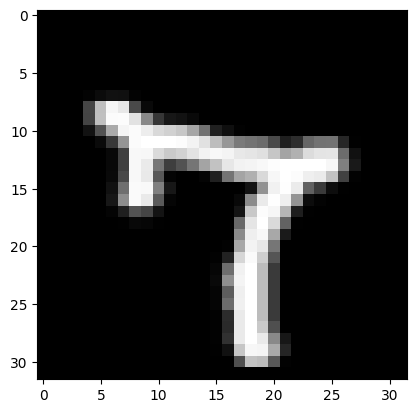

In [6]:
import matplotlib.pyplot as plt
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(type(images))
print(images.shape)
print(labels.shape)
#Printing the size of one image
print(images[1].numpy().squeeze().shape)

plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r');

In [12]:
import time

# Training loop    
train_losses = []
val_losses = []
num_epochs = 30
# Early Stopping parameters
patience = 5
best_val_loss = float('inf')
patience_counter = 0

start_time = time.time()  # Record the start time of the training

for epoch in range(num_epochs):
    epoch_start_time = time.time()  # Start time of the epoch

    train_loss = train(model, device, train_loader, optimizer, criterion, epoch)
    train_losses.append(train_loss)
    # Training loop with early stopping
    # Validation phase
    val_loss = validate(model, device, val_loader, criterion)
    val_losses.append(val_loss)
    print(f'Epoch {epoch},Training Loss: {train_loss:.4f},Validation Loss: {val_loss:.4f}')

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print("Early stopping triggered")
        break
    

end_time = time.time()  # Record the end time of the training
print(f"Training completed in {end_time - start_time:.2f} seconds.")


Epoch 0,Training Loss: 0.0390,Validation Loss: 0.0132
Epoch 1,Training Loss: 0.0081,Validation Loss: 0.0066
Epoch 2,Training Loss: 0.0049,Validation Loss: 0.0045
Epoch 3,Training Loss: 0.0039,Validation Loss: 0.0041
Epoch 4,Training Loss: 0.0035,Validation Loss: 0.0032
Epoch 5,Training Loss: 0.0029,Validation Loss: 0.0029
Epoch 6,Training Loss: 0.0027,Validation Loss: 0.0028
Epoch 7,Training Loss: 0.0025,Validation Loss: 0.0026
Epoch 8,Training Loss: 0.0023,Validation Loss: 0.0024
Epoch 9,Training Loss: 0.0022,Validation Loss: 0.0024
Epoch 10,Training Loss: 0.0021,Validation Loss: 0.0022
Epoch 11,Training Loss: 0.0021,Validation Loss: 0.0024
Epoch 12,Training Loss: 0.0019,Validation Loss: 0.0020
Epoch 13,Training Loss: 0.0018,Validation Loss: 0.0020
Epoch 14,Training Loss: 0.0018,Validation Loss: 0.0020
Epoch 15,Training Loss: 0.0017,Validation Loss: 0.0022
Epoch 16,Training Loss: 0.0017,Validation Loss: 0.0023
Epoch 17,Training Loss: 0.0016,Validation Loss: 0.0021
Epoch 18,Training Lo

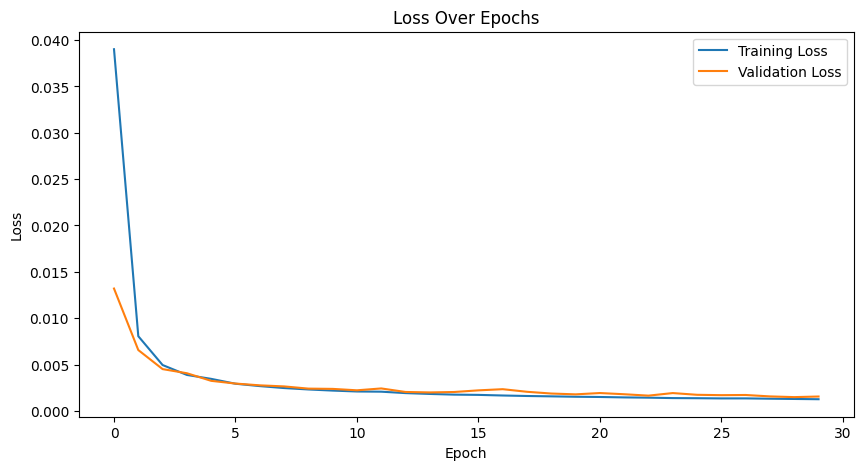

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


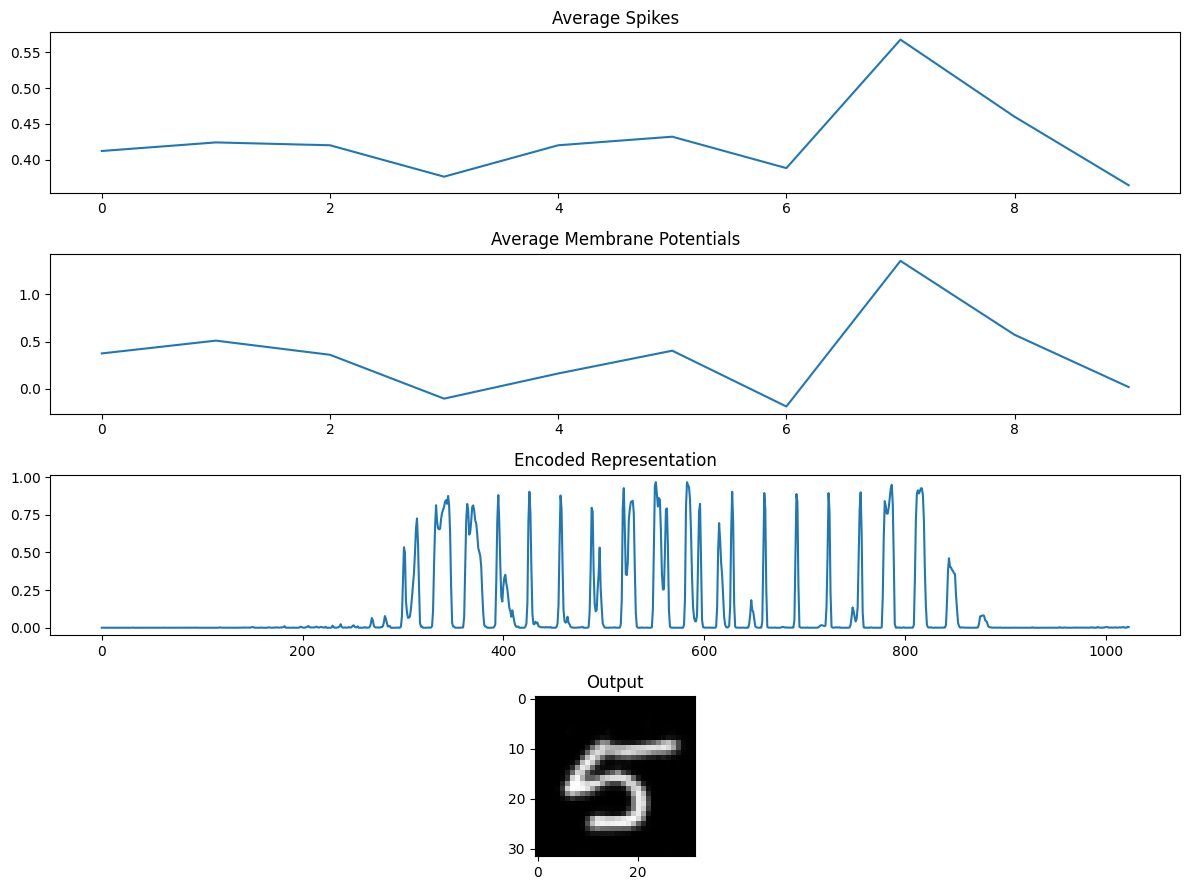

Test set: Average loss: 0.0016


In [16]:
# Test phase
model.eval()
test_losses = []
with torch.no_grad():
    for batch_idx, (data, _) in enumerate(test_loader):
        data = data.to(device)
        output, spikes, mem_pot = model(data)
        loss = criterion(output, data)
        test_losses.append(loss.item())

        if batch_idx == 0:  # Plot only for the first batch
            fig, axs = plt.subplots(4, 1, figsize=(12, 9))
            
            # Since spikes and mem_pot are likely to have multiple dimensions,
            # let's take an average over one of the dimensions to make them plottable.
            # Here, we average over the batch dimension (dim=0) and plot for one neuron across time steps.
            avg_spikes = spikes.mean(dim=0)[0]  # Averaging over the batch dimension.
            avg_mem_pot = mem_pot.mean(dim=0)[0]  # Averaging over the batch dimension.

            # Plot average spikes across the batch for the first neuron
            axs[0].plot(avg_spikes.cpu().numpy())
            axs[0].set_title('Average Spikes')

            # Plot average membrane potentials across the batch for the first neuron
            axs[1].plot(avg_mem_pot.cpu().numpy())
            axs[1].set_title('Average Membrane Potentials')

            # Plot encoded representation
            # Flatten the output and take the first example in the batch
            encoded_representation = output.cpu().numpy()[0].flatten()
            axs[2].plot(encoded_representation)
            axs[2].set_title('Encoded Representation')

            # Plot output (reconstruction)
            # Assuming the output is an image, reshape it accordingly.
            # The shape might need to be adjusted depending on the actual output of your model.
            reconstructed_image = output.cpu().numpy()[0].reshape(-1, input_size, input_size)
            axs[3].imshow(reconstructed_image[0], cmap='gray')
            axs[3].set_title('Output')

            plt.tight_layout()
            plt.show()
            break  # Stop after plotting the first batch

avg_test_loss = sum(test_losses) / len(test_losses)
print(f'Test set: Average loss: {avg_test_loss:.4f}')

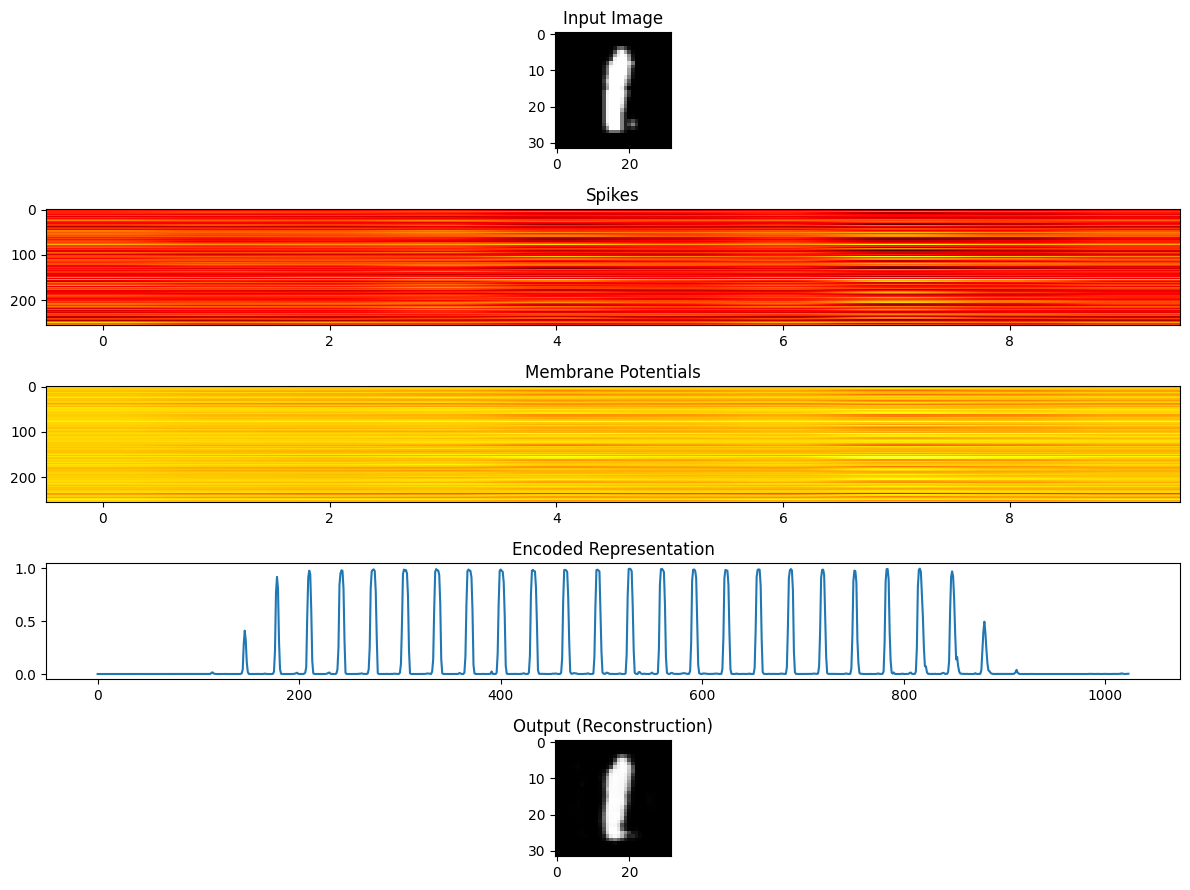

Test set: Average loss: 0.0016


In [19]:
# Test phase
model.eval()
test_losses = []

with torch.no_grad():
    for batch_idx, (data, _) in enumerate(test_loader):
        data = data.to(device)
        output, spikes, mem_pot = model(data)
        loss = criterion(output, data)
        test_losses.append(loss.item())

        if batch_idx == 0:  # Plot only for the first batch
            # Calculate the number of subplots needed based on the data to visualize
            num_subplots = 5  # input + spikes + membrane potentials + encoded representation + output
            fig, axs = plt.subplots(num_subplots, 1, figsize=(12, 9))

            # Plot the input image
            input_image = data.cpu().numpy()[0].squeeze()  # Assuming input is a single-channel image
            axs[0].imshow(input_image, cmap='gray')
            axs[0].set_title('Input Image')

            # Plot the spikes - averaged over the batch for visualization
            avg_spikes = spikes.mean(dim=0).squeeze()  # Taking the mean over the batch dimension
            axs[1].imshow(avg_spikes.cpu().numpy(), cmap='hot', aspect='auto')
            axs[1].set_title('Spikes')

            # Plot the membrane potentials - averaged over the batch for visualization
            avg_mem_pot = mem_pot.mean(dim=0).squeeze()  # Taking the mean over the batch dimension
            axs[2].imshow(avg_mem_pot.cpu().numpy(), cmap='hot', aspect='auto')
            axs[2].set_title('Membrane Potentials')

            # Plot the encoded representation - taking the first example in the batch
            encoded_representation = output.cpu().numpy()[0].flatten()
            axs[3].plot(encoded_representation)
            axs[3].set_title('Encoded Representation')

            # Plot the output (reconstruction) - reshaped to match the input dimensions
            reconstructed_image = output.cpu().numpy()[0].reshape(input_image.shape)
            axs[4].imshow(reconstructed_image, cmap='gray')
            axs[4].set_title('Output (Reconstruction)')

            plt.tight_layout()
            plt.show()
            break  # Stop after plotting the first batch

# Calculate the average test loss
avg_test_loss = sum(test_losses) / len(test_losses)
print(f'Test set: Average loss: {avg_test_loss:.4f}')

# New modifications

In [ ]:
! pip install torchsummary

In [ ]:
from torchsummary import summary

model.to(device)  # Ensure the model is on the correct device
summary(model, input_size=(1, input_size, input_size))  # input_size should match the model's input


# Caltech101 dataset

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import os

input_size = 32  # size of input to first convolutional layer

# Transformation for Caltech101 dataset
transform_caltech = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale if needed
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Adjust normalization for RGB images
])


In [ ]:
# Print all class names
print(caltech101_dataset.class_to_idx.keys())
